# Prelude

In [1]:
import pyiron_contrib

In [2]:
from pyiron import Project

In [3]:
pr = Project('MTPEX')

# Vasp Reference Calcs

In [4]:
element = 'W'

In [5]:
bcc = pr.create.structure.bulk(element, cubic=True).repeat(2)

In [6]:
bcc.plot3d()

NGLWidget()

In [7]:
dft_pr = pr.create_group('DFT')

## An EV Curve

In [8]:
ref = dft_pr.create.job.Vasp('ref')

In [9]:
ref.structure = bcc
ref.set_kpoints([1,1,1])

In [10]:
ref.server.cores = 4

In [11]:
ev = dft_pr.create.job.Murnaghan('bcc')
ev.ref_job = ref

In [12]:
ev.input

,Parameter,Value,Comment
0,num_points,11,number of sample points
1,fit_type,polynomial,"['polynomial', 'birch', 'birchmurnaghan', 'mur..."
2,fit_order,3,order of the fit polynom
3,vol_range,0.1,relative volume variation around volume define...
4,axes,"[x, y, z]",Axes along which the strain will be applied
5,strains,None,List of strains that should be calculated. If...
6,allow_aborted,0,The number of child jobs that are allowed to a...


In [13]:
ev.input['fit_order'] = 5
ev.input['vol_range'] = 0.2

In [14]:
ev.run()

The job bcc was saved and received the ID: 21207965
The job bcc_0_8 was saved and received the ID: 21207966
The job bcc_0_84 was saved and received the ID: 21207967
The job bcc_0_88 was saved and received the ID: 21207968
The job bcc_0_92 was saved and received the ID: 21207969
The job bcc_0_96 was saved and received the ID: 21207970
The job bcc_1_0 was saved and received the ID: 21207971
The job bcc_1_04 was saved and received the ID: 21207972
The job bcc_1_08 was saved and received the ID: 21207973
The job bcc_1_12 was saved and received the ID: 21207974
The job bcc_1_16 was saved and received the ID: 21207975
The job bcc_1_2 was saved and received the ID: 21207976


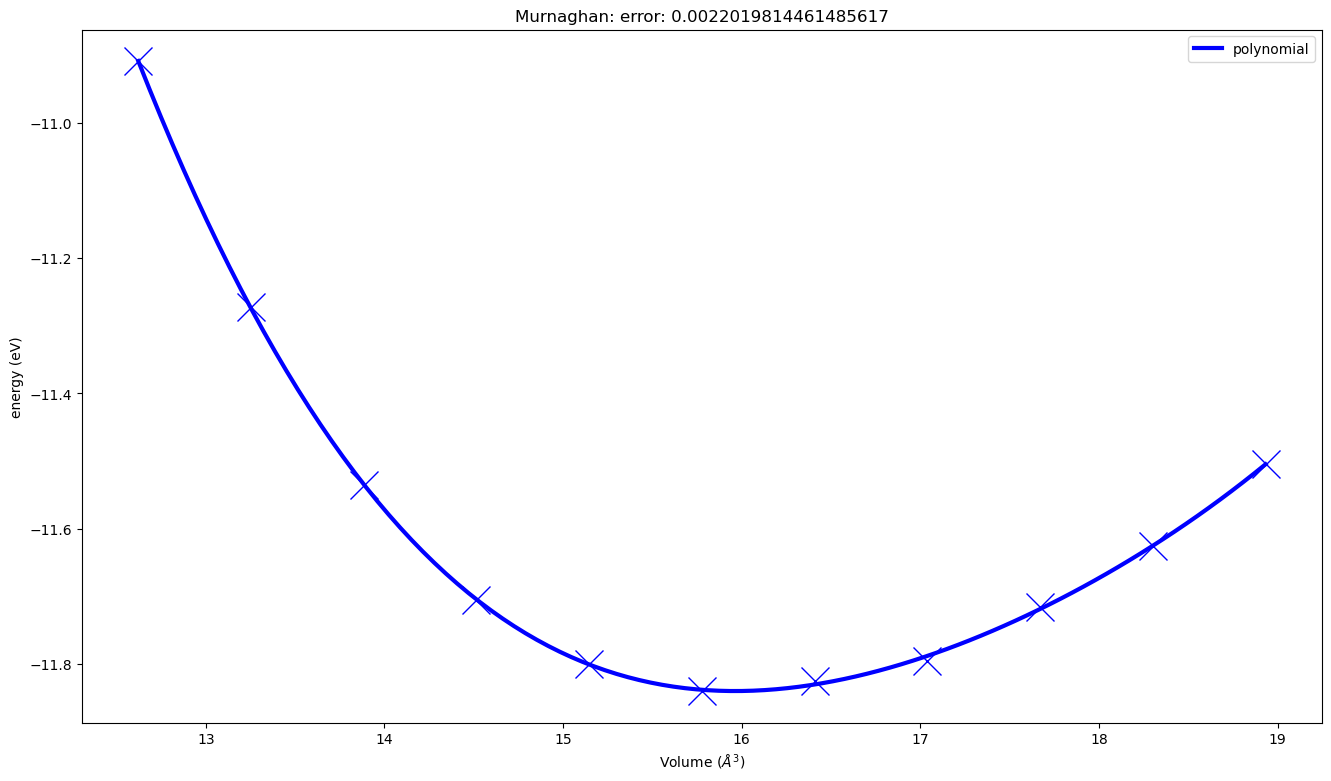

<Axes: title={'center': 'Murnaghan: error: 0.0022019814461485617'}, xlabel='Volume ($\\AA^3$)', ylabel='energy (eV)'>

In [15]:
ev.plot(per_atom=True)

## Some perturbed structures

In [16]:
rattle_pr = dft_pr.create_group('rattle')

In [17]:
for ev_job in dft_pr.load('bcc').child_project.iter_jobs(hamilton='Vasp', status='finished'):
    for i in range(3):
        j = rattle_pr.create.job.Vasp(ev_job.name + f'_rattle_{i}')
        j.structure = ev_job.structure.copy()
        j.structure.rattle(0.05, seed=i)
        j.set_kpoints([1,1,1])
        j.server.cores = 8
        j.run()

  0%|          | 0/11 [00:00<?, ?it/s]

The job bcc_0_8_rattle_0 was saved and received the ID: 21207977
The job bcc_0_8_rattle_1 was saved and received the ID: 21207978
The job bcc_0_8_rattle_2 was saved and received the ID: 21207979
The job bcc_0_84_rattle_0 was saved and received the ID: 21207980
The job bcc_0_84_rattle_1 was saved and received the ID: 21207981
The job bcc_0_84_rattle_2 was saved and received the ID: 21207982
The job bcc_0_88_rattle_0 was saved and received the ID: 21207983
The job bcc_0_88_rattle_1 was saved and received the ID: 21207984
The job bcc_0_88_rattle_2 was saved and received the ID: 21207985
The job bcc_0_92_rattle_0 was saved and received the ID: 21207986
The job bcc_0_92_rattle_1 was saved and received the ID: 21207987
The job bcc_0_92_rattle_2 was saved and received the ID: 21207988
The job bcc_0_96_rattle_0 was saved and received the ID: 21207989
The job bcc_0_96_rattle_1 was saved and received the ID: 21207990
The job bcc_0_96_rattle_2 was saved and received the ID: 21207991
The job bcc_1

# Collect Inside TrainingContainer

In [18]:
cont_pr = pr.create_group('container')

In [19]:
train = cont_pr.create.job.TrainingContainer('Structures')

In [20]:
for job in dft_pr.iter_jobs(hamilton='Vasp', status='finished', recursive=True):
    train.include_job(job)

  0%|          | 0/44 [00:00<?, ?it/s]

In [21]:
train.input.num_neighbors = 100
train.input.save_neigbhors = True

In [22]:
train.run()

The job Structures was saved and received the ID: 21208010


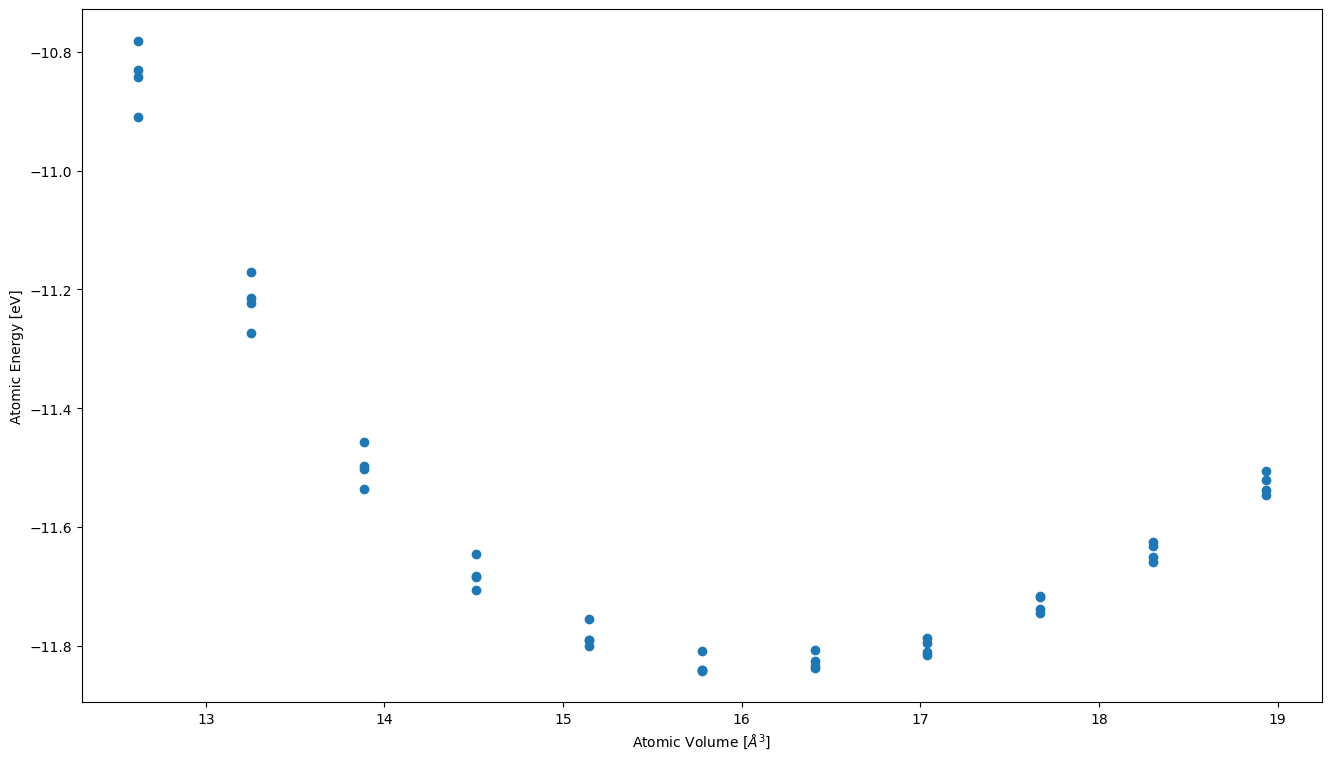

In [23]:
ev = train.plot.energy_volume();

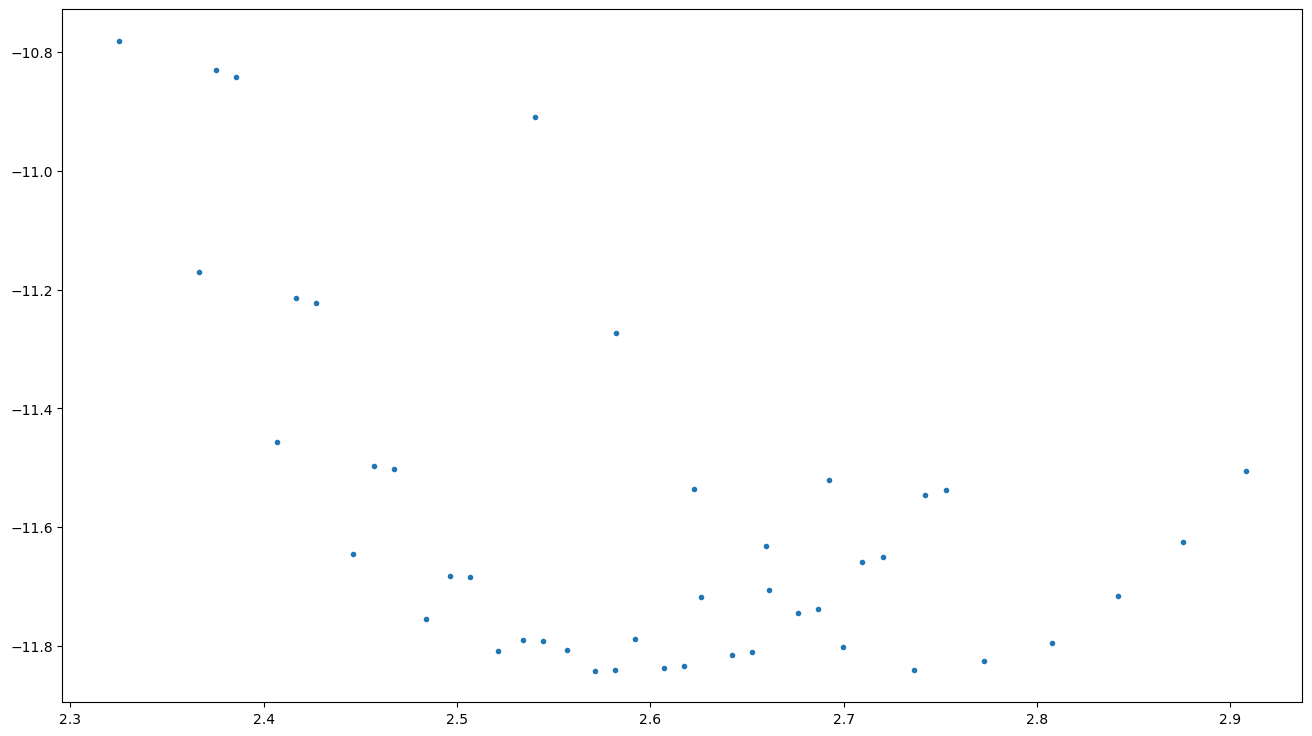

In [24]:
train.plot.energy_distance();

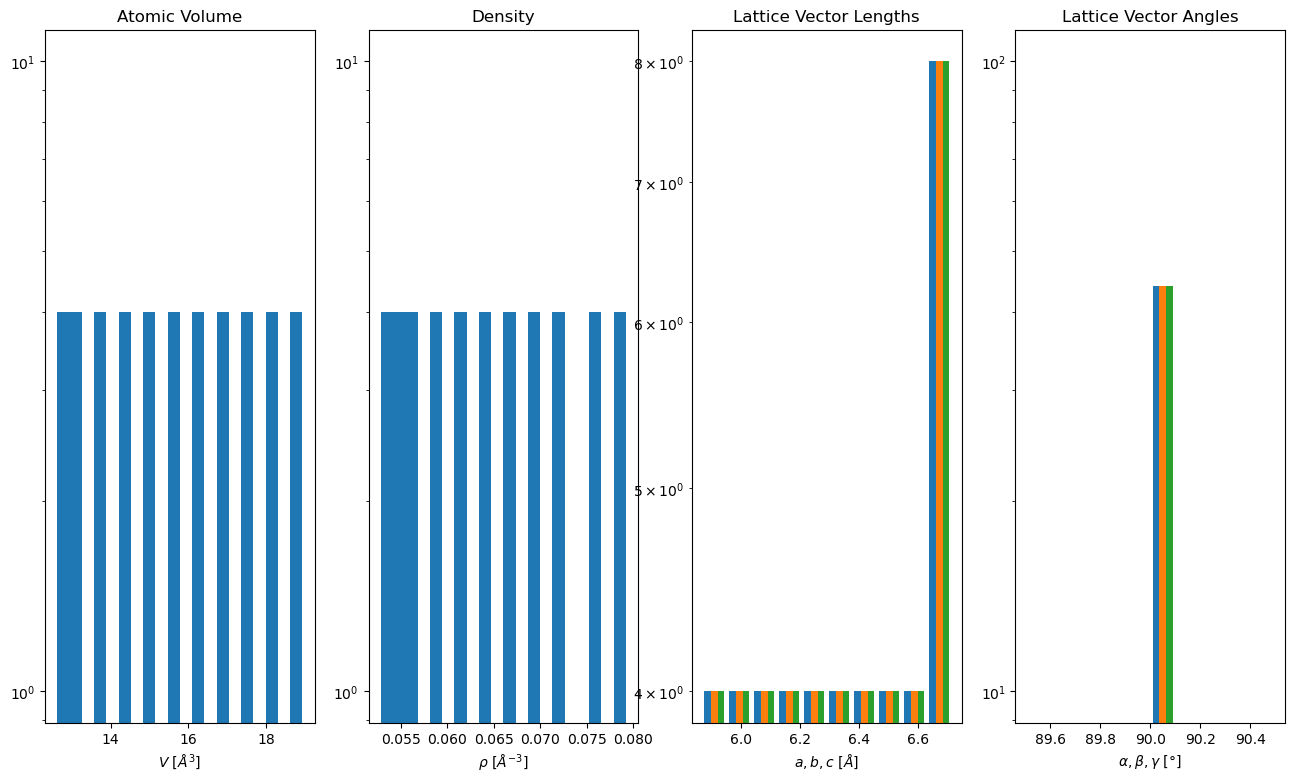

In [25]:
train.plot.cell();

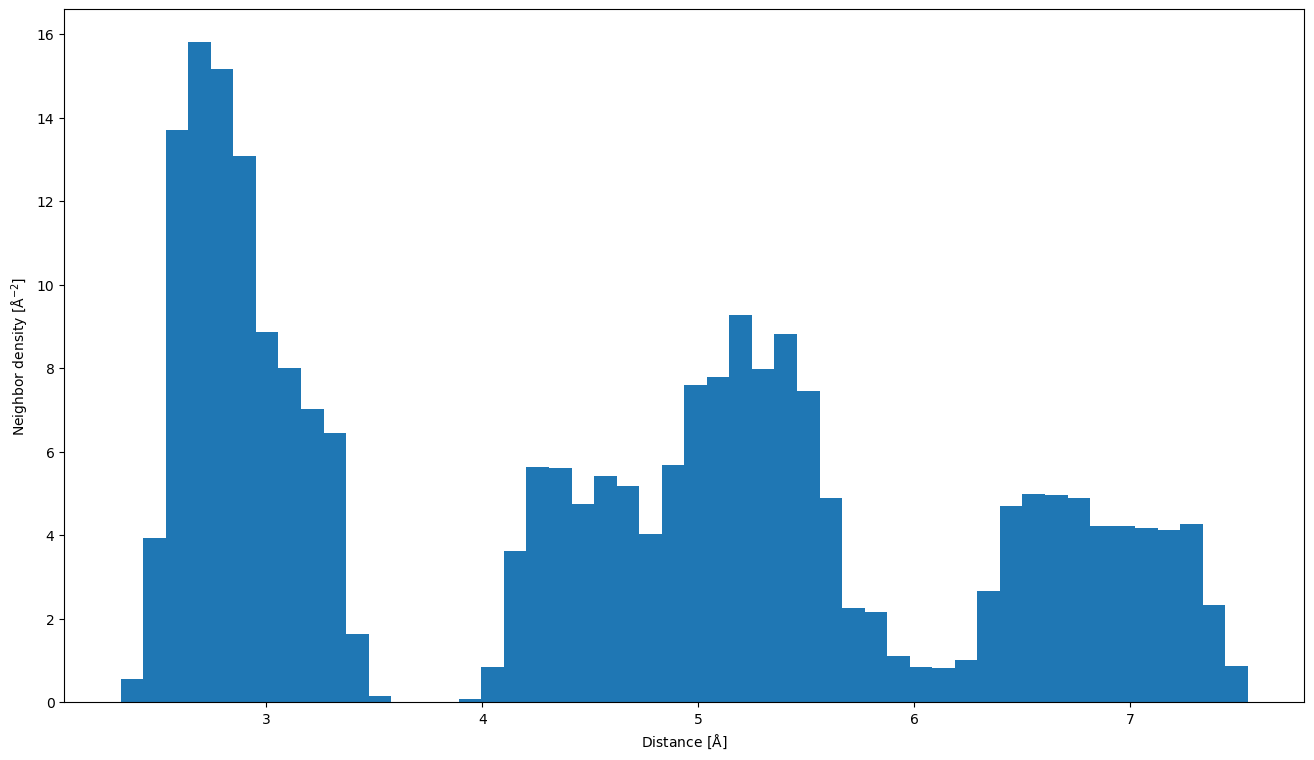

In [26]:
train.plot.distances(normalize=True)

# Fit MTP

In [27]:
fit_pr = pr.create_group('fit')

In [28]:
mtp = fit_pr.create.job.Mlip('MTP08')

In [29]:
mtp.add_training_data(cont_pr.load('Structures'))

In [30]:
mtp.input

,Parameter,Value,Comment
0,potential,16g.mtp,
1,filepath,auto,
2,energy-weight,1,
3,force-weight,0.01,
4,stress-weight,0.001,
5,iteration,1000,
6,min_dist,2.0,
7,max_dist,5.0,


In [31]:
mtp.input['potential'] = '08g.mtp' # filenames are from Alex' default potential templates, see MLIP docs
mtp.input['max_dist'] = 4 # outer potential cutoff radius

In [32]:
mtp.server.cores = 8
mtp.run()

The job MTP08 was saved and received the ID: 21208011


In [33]:
print(*mtp['training.log'])

MTPR from start.mtp, Database: training.cfg
 Random initialization of radial coefficients
 Rescaling...
    scaling = 0.833333333333333, condition number = 211.433765422221
    scaling = 0.909090909090909, condition number = 251.588543886794
    scaling = 1, condition number = 304.383473426976
    scaling = 1.1, condition number = 368.265748028534
    scaling = 1.2, condition number = 438.232343681583
 Rescaling to 0.833333333333333... done
 Rescaling...
    scaling = 0.694444444444445, condition number = 146.887482942807
    scaling = 0.757575757575758, condition number = 174.77168346897
    scaling = 0.833333333333333, condition number = 211.434028761851
    scaling = 0.916666666666667, condition number = 255.796060087795
    scaling = 1, condition number = 304.38347342699
 Rescaling to 0.694444444444445... done
 Rescaling...
    scaling = 0.578703703703704, condition number = 102.065931505933
    scaling = 0.631313131313131, condition number = 121.428681924783
    scaling = 0.694444

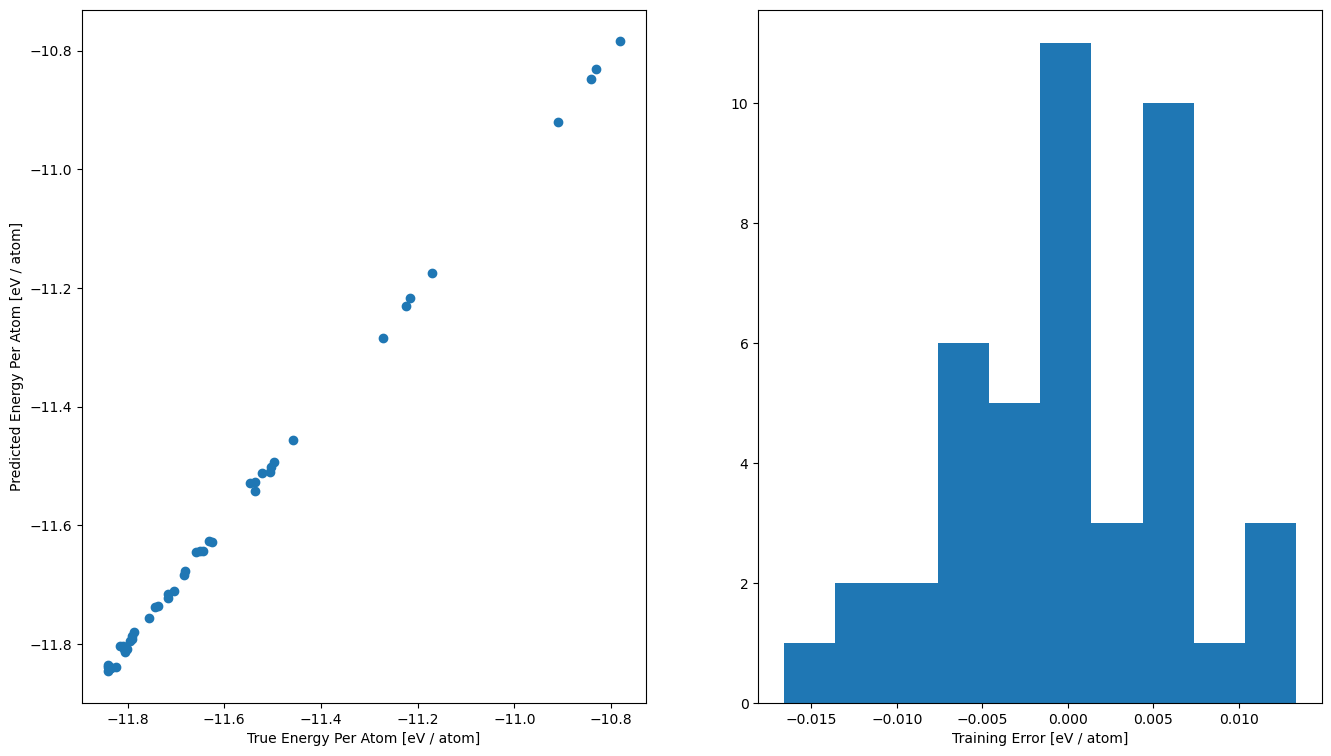

In [34]:
mtp.plot.energy_scatter_histogram()

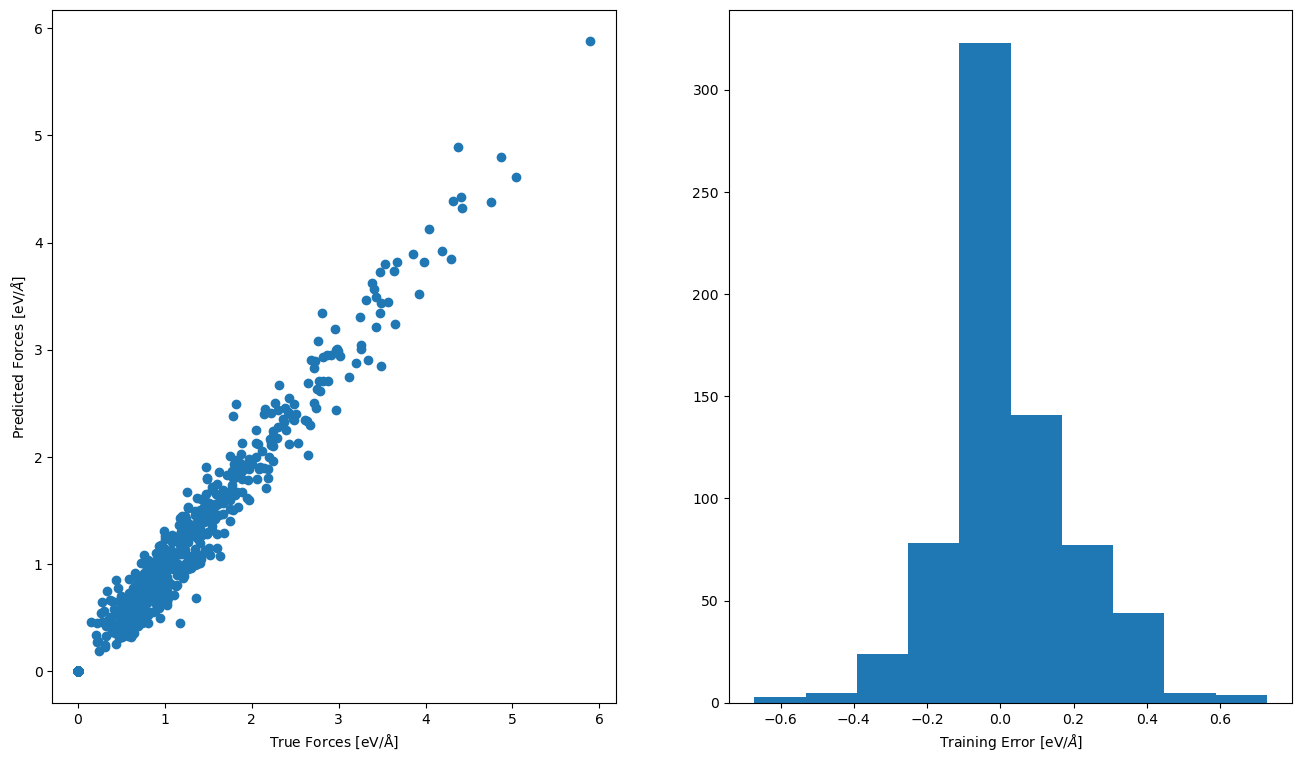

In [35]:
mtp.plot.force_scatter_histogram()

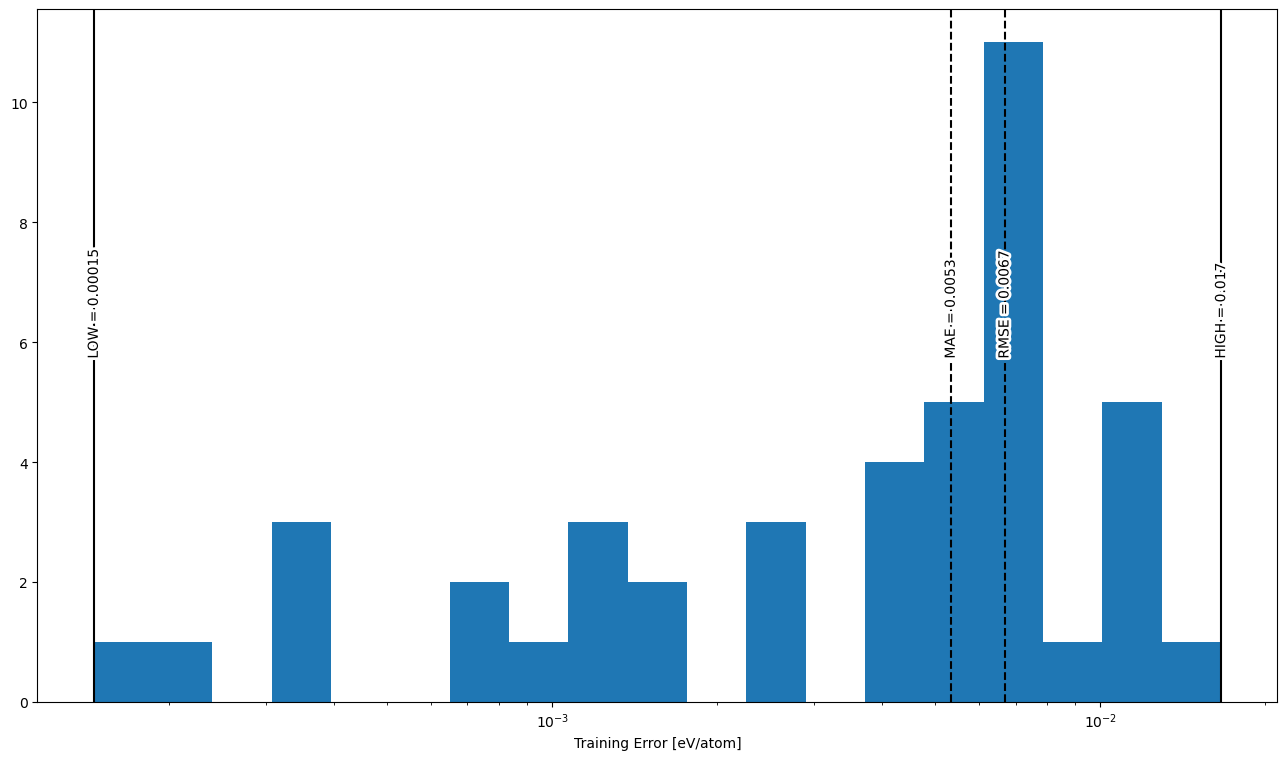

In [36]:
mtp.plot.energy_log_histogram()

# Run MTP

In [37]:
run_pr = pr.create_group('run')

In [42]:
j = run_pr.create.job.LammpsMlip('test_md')
j.structure = bcc
j.potential = mtp.get_lammps_potential()

In [46]:
j.calc_md(temperature=30, n_ionic_steps=1000, n_print=10) # naturally the potential here will be terrible, so let's not push it

In [44]:
j.run()

The job test_md was saved and received the ID: 21208013


In [45]:
j.animate_structures()

NGLWidget(max_frame=100)